In [23]:
import pandas as pd
import numpy as np
import math
import operator
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
import sys
import getopt
from random import randint
import os
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
#from sklearn import preprocessing
#import seaborn as sns
from random import *

In [12]:

#Plotting histogram

def plot_hist(data,binwidth):

    fig, ax = plt.subplots(figsize=(16,9))

    counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray',bins=np.arange(min(data), max(data) + binwidth, binwidth))

    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins)
    # Set the xaxis's tick labels to be formatted with 1 decimal place...
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))

    # Change the colors of bars at the edges...
    twentyfifth, seventyfifth = np.percentile(data, [25, 75])
    for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
        if rightside < twentyfifth:
            patch.set_facecolor('blue')
        elif leftside > seventyfifth:
            patch.set_facecolor('red')

    # Label the raw counts and the percentages below the x-axis...
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax.annotate('{:.0f}'.format(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, 18), textcoords='offset points', va='top', ha='center')

        # Label the percentages
    #     percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    #     ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
    #         xytext=(0, -32), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.title("Histogram",fontsize=20)
    plt.xlabel(" Values",fontsize=16)
    plt.ylabel("Count",fontsize=16)
    plt.subplots_adjust(bottom=0.15)


    blue_patch = mpatches.Patch(color='blue', label='Below 25%ile')
    yellow_patch = mpatches.Patch(color='yellow', label='Between 25-75%ile')
    red_patch = mpatches.Patch(color='red', label='Above 75%ile')
    plt.legend(handles=[blue_patch,yellow_patch,red_patch])
    plt.show()


In [13]:
#USing methods in pyod package
def od_algo(outliers_fraction,data_frame,algo_type):
    data=(data_frame['stat_value'].values.reshape(-1, 1))
    
    if algo_type=='iqr':
        #Manual method of classifying outliers by calculating IQR
        feature_desc=data_frame['stat_value'].describe().reset_index()
        ptile_25=int(feature_desc[feature_desc['index']=='25%']['stat_value'])
        ptile_75=int(feature_desc[feature_desc['index']=='75%']['stat_value'])
        iqr=ptile_75-ptile_25
        start_value=ptile_25-(1.5*iqr)
        end_value=ptile_75+(1.5*iqr)
        data_frame['prediction']=np.nan
        threshold=[start_value,end_value]
        
        for row in range(0,len(data_frame)):
            stat_row=data_frame['stat_value'][row]
            if (stat_row>=start_value and stat_row<=end_value):
                data_frame['prediction'][row]=0
            else:data_frame['prediction'][row]=1
        
        
        
    else:
    
        clf=identify_fit(algo_type,outliers_fraction) 
        clf.fit(data)
        scores_pred = clf.decision_function(data)*-1
        y_pred = clf.predict(data)
        threshold = stats.scoreatpercentile(scores_pred,100 *outliers_fraction)
        data_frame['scores']=scores_pred
        data_frame['prediction']=y_pred 
        #data_frame['threshold']=threshold

        
    data_frame=data_frame[data_frame['prediction']==1]
    data_frame.reset_index(inplace=True)
    return data_frame,threshold


def identify_fit(algo_type,outliers_fraction):
    random_state = np.random.RandomState(42)
    if algo_type=='hbos':
        clf=HBOS(contamination=outliers_fraction)
    elif algo_type=='cblof':
        clf=CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)
    elif algo_type=='iforest':
        clf=IForest(contamination=outliers_fraction,random_state=random_state)
    elif algo_type=='knn':
        clf=KNN(contamination=outliers_fraction)
    elif algo_type=='aknn':
        clf=KNN(method='mean',contamination=outliers_fraction)
    return clf

In [19]:
def outlier_function(data_frame,binwidth,algo_type):
    
    data_frame=data_frame[pd.to_numeric(data_frame['stat_value'], errors='coerce').notnull()]
    data_frame[['stat_value']] = data_frame[['stat_value']].apply(pd.to_numeric)
    print(data_frame['stat_value'].describe())
    data=data_frame['stat_value'].values
    
    #Plotting histogram
    plot_hist(data,binwidth)
    
    #Outlier Algo
    data_frame,threshold=od_algo(outliers_fraction,data_frame,algo_type)
    print("----------------OUTPUT---------------")
    #print("Threshold score: ",round(threshold,2))
    print("\n\n")
    data_frame=data_frame[['index','stat_value']]
    print(data_frame.round(2))
    data_frame.to_excel("Outliers.xlsx",sheet_name='outliers',index=False)

count    1001.000000
mean       51.097902
std        28.859771
min         1.000000
25%        27.000000
50%        53.000000
75%        76.000000
max       106.000000
Name: stat_value, dtype: float64


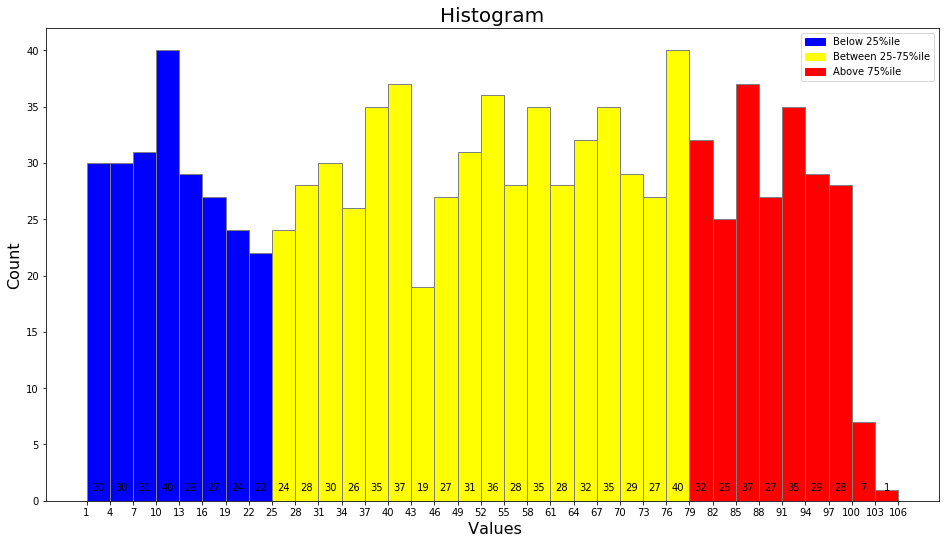

----------------OUTPUT---------------



    index  stat_value
0      15          97
1      16          97
2      34          98
3      47          98
4      61          96
5      82         100
6      86          97
7     111          99
8     205         100
9     268          98
10    301          97
11    306          97
12    381          97
13    382          96
14    384          98
15    398         100
16    406          96
17    417          96
18    469          99
19    475          97
20    531          97
21    542          99
22    571          97
23    586          96
24    591          96
25    614          99
26    637          97
27    640         100
28    643          98
29    647         100
30    662          98
31    663          99
32    666          97
33    667         100
34    684          97
35    695          97
36    697          97
37    716          96
38    756          96
39    769          97
40    800          98
41    809          96
42    814    

In [33]:
binwidth=3
outliers_fraction = 0.05
algo_type='hbos'

#s = np.random.standard_normal(size=10000)
s=[]
for i in range(0,1000):
    s.append(randint(1, 100))
#s=list(s)
s.append(106)
data_frame=pd.DataFrame({"stat_value":s})
data_frame.to_csv("sequence.csv")
#data_frame.to_excel("sequence.xlsx")

outlier_function(data_frame,binwidth,algo_type)